# 01_Library

## install

In [1]:
! pip install -q torchmetrics

## import

In [2]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm
import torchmetrics as tm

In [3]:
!python --version

Python 3.10.14


In [4]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tqdm, tm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.24.3
pandas --> 2.2.2
cv2 --> 4.10.0
PIL --> 10.3.0
sklearn --> 1.5.0
torch --> 2.3.0
torchvision --> 0.18.0
tqdm --> 4.66.4
torchmetrics --> 1.4.0.post0


------------------

# 02_Utils

## device

In [5]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## system

In [6]:
system= "local"

if system== "local":
    drive_path= r"./"
    dataset_folder= './UTKFace/'
elif system== "colab":
    drive_path= r"/content/drive/MyDrive/Catalist/0_age estimation/"
    dataset_folder= '/content/UTKFace/'

## avragemeter

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## number of parameter fn

In [8]:
def num_trainable_params(model):
  nums= sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

## drive mount

In [9]:
if system== "colab":
    from google.colab import drive
    drive.mount('/content/drive')

----------------

# 03_Data



In [10]:
if system== "colab":
    data_path= os.path.join(drive_path,'UTKFace.tar.gz')
    ! tar -xzf "{data_path}" -C '/content/'

--------

# 04_EDA (Exploratory Data Analysis)

## show sample of images

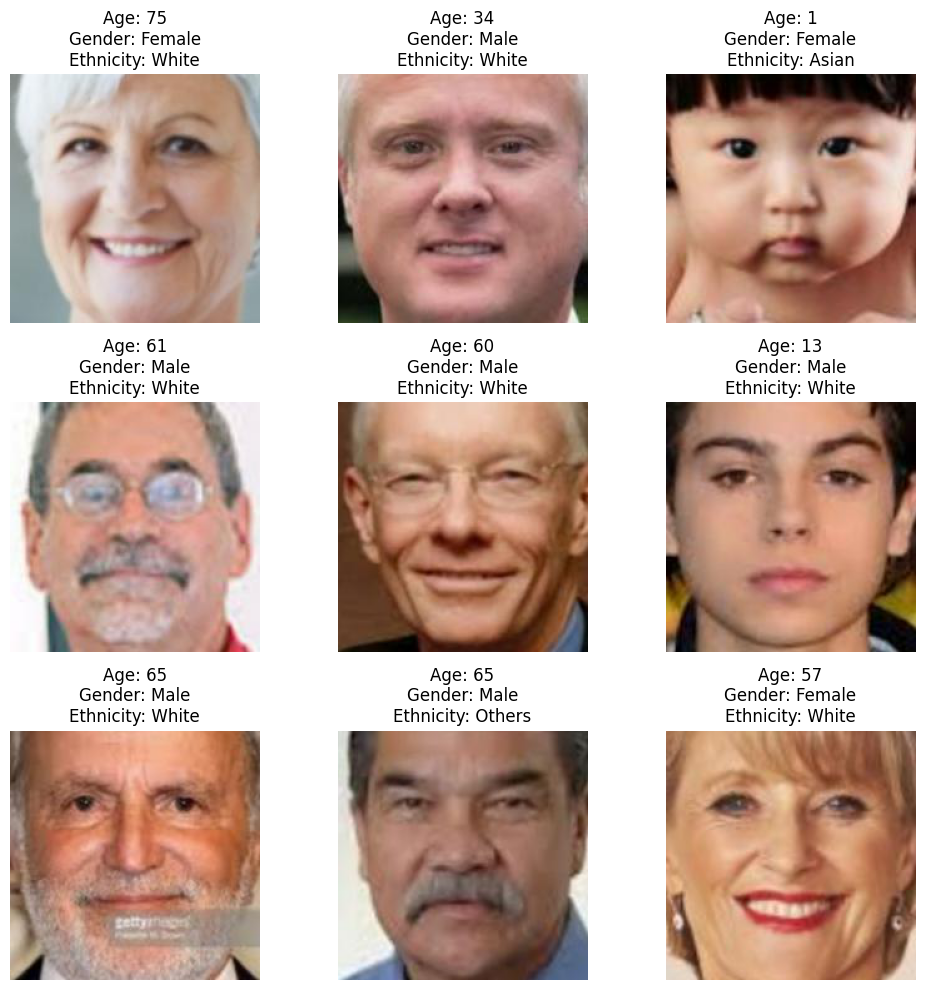

In [11]:
def show_random_samples(num_samples= 9):
    image_files= os.listdir(dataset_folder)
    selected_image_files= random.sample(image_files, num_samples)

    plt.figure(figsize= (10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path= os.path.join(dataset_folder, image_file)
        age, gender, ethnicity= image_file.split('_')[:3]

        image = Image.open(image_path)

        gender= 'Male' if int(gender)== 0 else 'Female'
        ethnicity= ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_samples()

## create csv file contain list of images

In [12]:
image_names, ages, ethnicities, genders= [], [], [], []

for filename in os.listdir(dataset_folder):
    if filename.endswith('.jpg'):

        parts= filename.split('_')
        if len(parts) < 4:
          print(filename)
          continue

        age= int(parts[0])
        gender= 'Male' if int(parts[1]) == 0 else 'Female'
        ethnicity= ['White', 'Black', 'Asian', 'Indian', 'Others'][int(parts[2])]

        if age > 80:
          continue

        image_names.append(filename)
        ages.append(age)
        ethnicities.append(ethnicity)
        genders.append(gender)

data= {
    'image_name': image_names,
    'age': ages,
    'ethnicity': ethnicities,
    'gender': genders
}
df= pd.DataFrame(data)

csv_filename = os.path.join(drive_path, 'utkface_dataset.csv')
df.to_csv(csv_filename, index=False)

print(f"CSV file '{csv_filename}' created successfully.")

39_1_20170116174525125.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg
61_1_20170109150557335.jpg.chip.jpg
CSV file './utkface_dataset.csv' created successfully.


In [13]:
df

,image_name,age,ethnicity,gender
0,10_0_0_20161220222308131.jpg.chip.jpg,10,White,Male
1,10_0_0_20170103200329407.jpg.chip.jpg,10,White,Male
2,10_0_0_20170103200522151.jpg.chip.jpg,10,White,Male
3,10_0_0_20170103233459275.jpg.chip.jpg,10,White,Male
4,10_0_0_20170104013211746.jpg.chip.jpg,10,White,Male
...,...,...,...,...
23160,9_1_3_20161220222856346.jpg.chip.jpg,9,Indian,Female
23161,9_1_3_20170104222949455.jpg.chip.jpg,9,Indian,Female
23162,9_1_4_20170103200637399.jpg.chip.jpg,9,Others,Female
23163,9_1_4_20170103200814791.jpg.chip.jpg,9,Others,Female


## histogram

### age

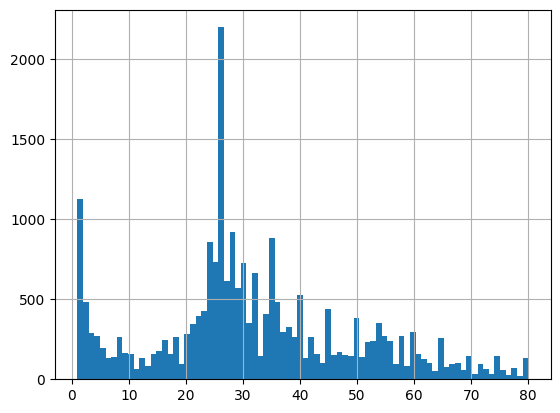

In [14]:
df['age'].hist(bins= len(df.age.unique()));

### gender

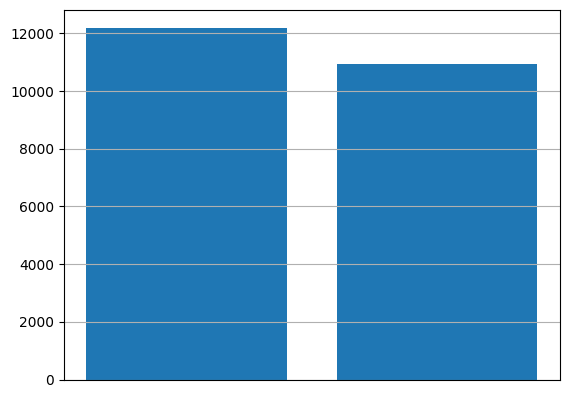

In [15]:
df['gender'].hist(bins= len(df.gender.unique()), rwidth= 0.8);

In [16]:
df.gender.value_counts()

gender
Male      12208
Female    10957
Name: count, dtype: int64

### race

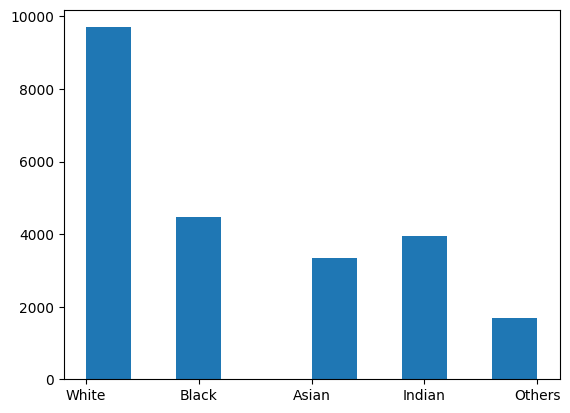

In [17]:
plt.hist(df.ethnicity);

## crosstab

### age-race

In [18]:
pd.crosstab(df.gender, df.ethnicity)

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1810,2182,1698,930,4337
Male,1538,2296,2254,759,5361


## boxplot & violinplot

### gender

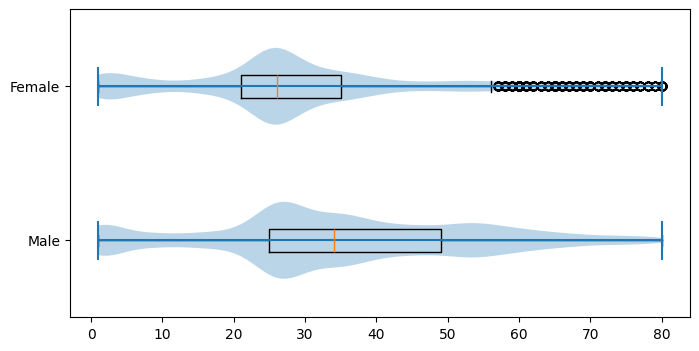

In [19]:
plt.figure(figsize= (8,4))
plt.boxplot([df.age[df.gender== sex] for sex in df.gender.unique()],
            tick_labels= df.gender.unique(),
            vert= False)
plt.violinplot([df.age[df.gender== sex] for sex in df.gender.unique()],
               vert= False);

### race

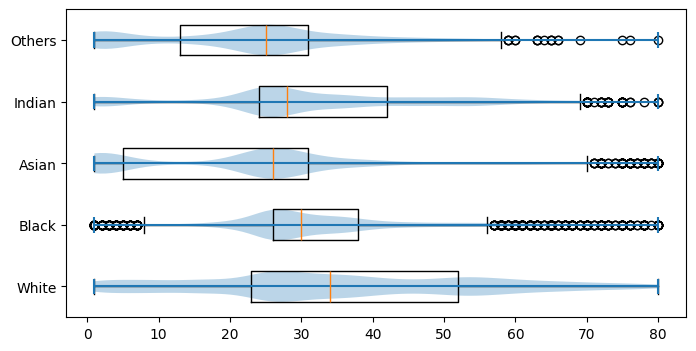

In [20]:
plt.figure(figsize= (8,4))
plt.boxplot([df.age[df.ethnicity== race] for race in df.ethnicity.unique()],
            tick_labels= df.ethnicity.unique(),
            vert= False)
plt.violinplot([df.age[df.ethnicity== race] for race in df.ethnicity.unique()],
               vert= False);

----------

# 05_Split data

In [21]:
df_train_raw, df_test= train_test_split(df, test_size= 0.2,
                                        stratify= df.age, random_state= 42)
df_train, df_valid= train_test_split(df_train_raw, test_size= 0.2,
                                          stratify= df_train_raw.age, random_state= 42)

print(f'train: {df_train.shape}, valid: {df_valid.shape}, test: {df_test.shape}')

train: (14825, 4), valid: (3707, 4), test: (4633, 4)


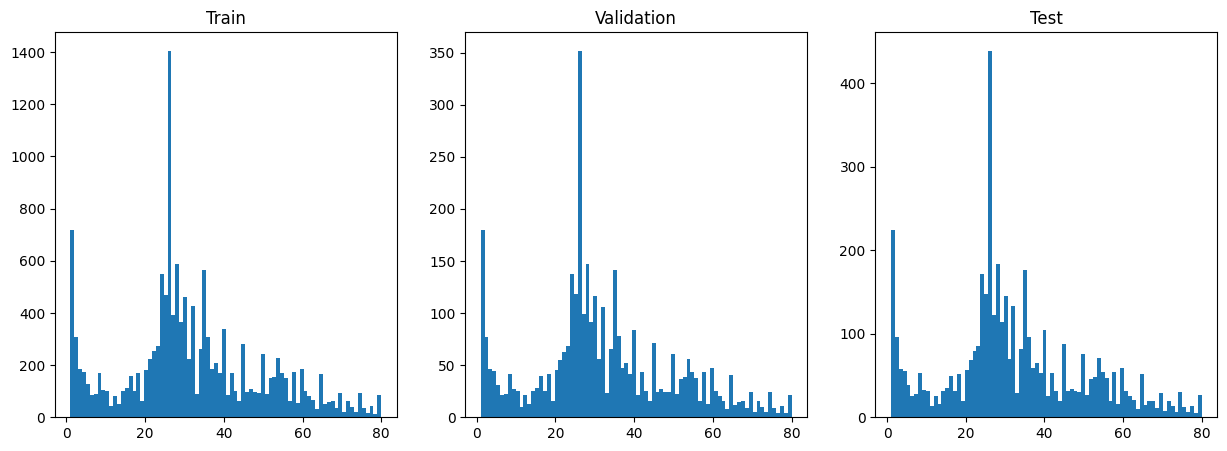

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

In [23]:
df_train.to_csv(os.path.join(drive_path,'train_set.csv'), index= False)
df_valid.to_csv(os.path.join(drive_path, 'valid_set.csv'), index= False)
df_test.to_csv(os.path.join(drive_path, 'test_set.csv'), index= False)

print('All CSV files created successfully.')

All CSV files created successfully.


--------

# 06_Transform

In [24]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees= 15),
    transforms.ColorJitter(brightness= 0.2, contrast= 0.2, saturation= 0.2, hue= 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225]),
])

----------

# 07_Custom dataset

In [25]:
class UTK_Dataset(Dataset):
  def __init__(self, root_dir, csv_file, transform):
    self.root_dir, self.csv_file, self.transform= root_dir, csv_file, transform
    self.data= pd.read_csv(self.csv_file)
    self.gender_map= {'Male': 0, 'Female': 1}
    self.race_map= {'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Others': 4}

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample= self.data.iloc[idx, :]
    img_name= sample.image_name
    image= Image.open(os.path.join(self.root_dir, img_name))
    image= self.transform(image)

    age= torch.tensor([sample.age], dtype= torch.float32)
    gender= torch.tensor(self.gender_map[sample.gender], dtype= torch.int32)
    race= torch.tensor(self.race_map[sample.ethnicity], dtype= torch.int32)
    return image, age, gender.long(), race.long()

In [26]:
train_dataset= UTK_Dataset(dataset_folder, 'train_set.csv', train_transform)
valid_dataset= UTK_Dataset(dataset_folder, 'valid_set.csv', test_transform)
test_dataset= UTK_Dataset(dataset_folder, 'test_set.csv', test_transform)

In [27]:
smp= random.randint(0,len(train_dataset))
img, ag, gndr, rc= train_dataset[smp]
print(img.shape, ag, gndr, rc)

torch.Size([3, 128, 128]) tensor([35.]) tensor(1) tensor(3)


----------

# 08_DataLoader

In [28]:
train_loader= DataLoader(train_dataset, batch_size= 128, shuffle= True)
valid_loader= DataLoader(valid_dataset, batch_size= 256, shuffle= False)
test_loader= DataLoader(test_dataset, batch_size= 256, shuffle= False)

print("train batch size:",train_loader.batch_size,
     ", num of batch:", len(train_loader))
print("valid batch size:",valid_loader.batch_size,
     ", num of batch:", len(valid_loader))
print("Test batch size:",test_loader.batch_size,
     ", num of batch:", len(test_loader))

train batch size: 128 , num of batch: 116
valid batch size: 256 , num of batch: 15
Test batch size: 256 , num of batch: 19


In [29]:
imgs, ags, gndrs, rcs= next(iter(train_loader));
print(imgs.shape, ags.shape, gndrs.shape, rcs.shape)

torch.Size([128, 3, 128, 128]) torch.Size([128, 1]) torch.Size([128]) torch.Size([128])


--------

# 09_Model

In [30]:
class GR_classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.Model= models.resnet18(weights= models.ResNet18_Weights.IMAGENET1K_V1)
    self.Model.fc= nn.Identity()
    self.gender_fc= nn.LazyLinear(2)
    self.race_fc= nn.LazyLinear(5)

  def forward(self, x):
    y= self.Model(x)
    y_gender= self.gender_fc(y)
    y_race= self.race_fc(y)
    return y_gender, y_race

In [31]:
gr_model= GR_classifier()
g, r= gr_model(imgs)
g.shape, r.shape

D:\program\Anaconda\envs\GPU_pytorch\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(torch.Size([128, 2]), torch.Size([128, 5]))

-------

# 10_Configuration

In [32]:
lr= 0.02
momentum= 0.9
weight_decay= 1e-4
gr_model.to(device)
optimizer= optim.SGD(gr_model.parameters(), lr,
                     momentum= momentum,
                     weight_decay= weight_decay)
g_loss_fn= nn.CrossEntropyLoss()
r_loss_fn= nn.CrossEntropyLoss()
g_metric= tm.Accuracy(task="multiclass", num_classes= 2).to(device)
r_metric= tm.Accuracy(task="multiclass", num_classes= 5).to(device)

-----------

# 11_One Epoch fn

## train

In [33]:
def train_one_epoch(model, train_loader, g_loss_fn, r_loss_fn, optimizer, g_metric, r_metric, epoch= None):
  model.train()
  g_loss_train= AverageMeter()
  g_metric.reset()
  r_loss_train= AverageMeter()
  r_metric.reset()

  with tqdm.tqdm(train_loader, unit= 'batch') as tepoch:
    for inputs, _, gender, race in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs= inputs.to(device)
      gender, race= gender.to(device), race.to(device)
      output_g, output_r= model(inputs)
      loss_g, loss_r= g_loss_fn(output_g, gender), r_loss_fn(output_r, race)
      loss= loss_g+ loss_r
        
      loss.backward()  
      optimizer.step()
      optimizer.zero_grad()

      g_loss_train.update(loss_g.item(), n=len(gender))
      r_loss_train.update(loss_r.item(), n=len(race))
      g_metric.update(output_g, gender)
      r_metric.update(output_r, race)
      tepoch.set_postfix(metric= f" {100* g_metric.compute().item():.2f}, {100* r_metric.compute().item():.2f}")

  return model, g_loss_train.avg, r_loss_train.avg, g_metric.compute().item(), r_metric.compute().item()

## evalution

In [34]:
def evaluate(model, test_loader, g_loss_fn, r_loss_fn, g_metric, r_metric):
  model.eval()
  g_loss_eval= AverageMeter()
  r_loss_eval= AverageMeter()
  g_metric.reset()
  r_metric.reset()

  with torch.inference_mode():
    for inputs, _, gender, race in test_loader:
      inputs= inputs.to(device)
      gender, race= gender.to(device), race.to(device)
      output_g, output_r= model(inputs)
      loss_g, loss_r= g_loss_fn(output_g, gender), r_loss_fn(output_r, race)

      g_loss_eval.update(loss_g.item(), n= len(gender))
      r_loss_eval.update(loss_r.item(), n= len(race))
      g_metric(output_g, gender)
      r_metric(output_r, race)

  return g_loss_eval.avg, r_loss_eval.avg, g_metric.compute().item(), r_metric.compute().item()

-------

# 12_Experiments before the main training

## base metrics

In [35]:
base_loss_g, base_loss_r= [], []
base_metric_g, base_metric_r= [], []
for i in range(10):
  gr_model= GR_classifier().to(device)
  inputs, _, gender, race= next(iter(train_loader))
  inputs= inputs.to(device)
  gender, race= gender.to(device), race.to(device)

  with torch.no_grad():
    output_g, output_r= gr_model(inputs)
    base_loss_g.append(g_loss_fn(output_g, gender))
    base_loss_r.append(r_loss_fn(output_r, race))
    base_metric_g.append(g_metric(output_g, gender))
    base_metric_r.append(r_metric(output_r, race))

print('gender:')
print(f'base loss: {sum(base_loss_g)/len(base_loss_g):.4},')
print(f'base metric: {sum(base_metric_g)/ len(base_metric_g):.4}')
print('race:')
print(f'base loss: {sum(base_loss_r)/len(base_loss_r):.4},')
print(f'base metric: {sum(base_metric_r)/ len(base_metric_r):.4}')

gender:
base loss: 0.7915,
base metric: 0.5047
race:
base loss: 1.844,
base metric: 0.207


## overfit on subset of data

In [52]:
num_epochs= 50
mini_train_size= 1000
mini_batch_size= 50

_, mini_train_dataset= random_split(train_dataset,
                                   (len(train_dataset)- mini_train_size,
                                    mini_train_size))
mini_train_loader= DataLoader(mini_train_dataset, mini_batch_size)
gr_model= GR_classifier().to(device)
optimizer= torch.optim.SGD(gr_model.parameters(), lr= 1e-2, momentum= 0.9)

for epoch in range(num_epochs):
  age_model, _, _, _, _ = train_one_epoch(gr_model, mini_train_loader, g_loss_fn, r_loss_fn,
                                    optimizer, g_metric, r_metric, epoch)

Epoch 4:  40%|████████████████████                              | 8/20 [00:03<00:05,  2.37batch/s, metric=86.50, 73.50]


KeyboardInterrupt: 

## grid search

In [37]:
num_epochs= 3
# 0.1,
for lr in [0.01, 0.001, 0.0001]:
  print(f'LR={lr}')
  gr_model= GR_classifier().to(device)
  optimizer= optim.SGD(gr_model.parameters(), lr= lr,
                       weight_decay= 1e-4, momentum= 0.9)

  for epoch in range(num_epochs):
    gr_model, _, _, _, _= train_one_epoch(gr_model, train_loader, g_loss_fn, r_loss_fn,
                                          optimizer, g_metric, r_metric, epoch)
  print()

LR=0.01


Epoch 2: 100%|███████████████████████████████████████████████| 116/116 [01:38<00:00,  1.18batch/s, metric=90.91, 82.07]



LR=0.001


Epoch 2: 100%|███████████████████████████████████████████████| 116/116 [01:39<00:00,  1.16batch/s, metric=88.40, 75.31]



LR=0.0001


Epoch 2: 100%|███████████████████████████████████████████████| 116/116 [01:42<00:00,  1.13batch/s, metric=78.39, 54.86]

In [39]:
num_epochs= 3

for lr in [0.03, 0.01, 0.008]:
  for wd in [1e-4, 0.]:
    print(f'LR={lr}, WD={wd}')
    gr_model= GR_classifier().to(device)
    optimizer= optim.SGD(gr_model.parameters(), lr= lr, weight_decay= wd, momentum= 0.9)

    for epoch in range(num_epochs):
      gr_model, _, _, _, _= train_one_epoch(gr_model, train_loader, g_loss_fn, r_loss_fn,
                                            optimizer, g_metric, r_metric, epoch)
    print()

LR=0.03, WD=0.0001


Epoch 2: 100%|███████████████████████████████████████████████| 116/116 [01:39<00:00,  1.16batch/s, metric=88.34, 75.75]



LR=0.03, WD=0.0


Epoch 2: 100%|███████████████████████████████████████████████| 116/116 [01:24<00:00,  1.37batch/s, metric=86.55, 71.72]



LR=0.01, WD=0.0001


Epoch 2: 100%|███████████████████████████████████████████████| 116/116 [01:37<00:00,  1.19batch/s, metric=91.37, 81.15]



LR=0.01, WD=0.0


Epoch 2: 100%|███████████████████████████████████████████████| 116/116 [01:35<00:00,  1.21batch/s, metric=91.51, 81.67]



LR=0.008, WD=0.0001


Epoch 2: 100%|███████████████████████████████████████████████| 116/116 [01:36<00:00,  1.20batch/s, metric=91.16, 81.57]



LR=0.008, WD=0.0


Epoch 2: 100%|███████████████████████████████████████████████| 116/116 [01:33<00:00,  1.25batch/s, metric=90.71, 81.61]

----------

# 13_Training

In [ ]:
loss_train_hist= []
loss_valid_hist= []

metric_train_hist= []
metric_valid_hist= []

best_loss_valid= torch.inf
epoch_counter= 0

age_model= Age_estimator().to(device)

In [ ]:
lr= 0.01
wd= 1e-4
optimizer= optim.SGD(age_model.parameters(), lr= lr,
                     weight_decay= wd, momentum= 0.9)

In [ ]:
num_epochs= 15

for epoch in range(num_epochs):
  age_model, loss_train, metric_train= train_one_epoch(age_model, train_loader,
                                                       loss_fn, optimizer,
                                                       metric, epoch)
  loss_valid, metric_valid= evaluate(age_model, valid_loader,
                                     loss_fn, metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(age_model, os.path.join(drive_path, 'age_model.pt'))
    best_loss_valid= loss_valid
    print('Model Saved!')

  print(f'Valid: Loss= {loss_valid:.4}, Metric= {metric_valid:.4}')
  print()

  epoch_counter += 1

-----

# 14_Learning curve

## loss

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(loss_train_hist)), loss_train_hist, 'k-', label='Train')
plt.plot(range(len(loss_valid_hist)), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

## metric

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(metric_train_hist)), metric_train_hist, 'k-', label='Train')
plt.plot(range(len(metric_valid_hist)), metric_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('metric')
plt.grid(True)
plt.legend()

----------

# 15_Test

In [ ]:
model_path= os.path.join(drive_path, 'age_model.pt')
age_model= torch.load(model_path)
age_model.eval()

_, metric_train= evaluate(age_model, train_loader, loss_fn, metric)
_, metric_valid= evaluate(age_model, valid_loader, loss_fn, metric)
_, metric_test= evaluate(age_model, test_loader, loss_fn, metric)

print(f'train: {metric_train}')
print(f'valid: {metric_valid}')
print(f'Test: {metric_test}')

In [ ]:
df= pd.read_csv(os.path.join(drive_path, 'test_set.csv'))
test_image_name= df.iloc[random.randint(0, df.shape[0])].image_name
test_image_path= os.path.join(dataset_folder, test_image_name)
img= Image.open(test_image_path).convert('RGB')
img_tensor= test_transform(img).unsqueeze(0)
with torch.inference_mode():
  preds= age_model(img_tensor.to(device)).item()
real_age= test_image_name.split('_')[0]
print(f"Real: {real_age}, Predicted: {round(preds)}")
img

-------

# 16_Inference

In [ ]:
!pip install face-recognition
import face_recognition

In [ ]:
def inference(image_path, transform, model, face_detection= False):
  if face_detection:
    img= face_recognition.load_image_file(image_path)
    top, right, bottom, left= face_recognition.face_locations(img)[0]
    img_crop= Image.fromarray(img[top:bottom, left:right])
  else:
    img_crop= Image.open(image_path).convert('RGB')

  img_tensor= transform(img_crop).unsqueeze(0)
  with torch.inference_mode():
    preds= model(img_tensor.to(device)).item()

  return preds, img_crop

In [ ]:
preds, img= inference(os.path.join(drive_path, 'test_image.jpeg'),
          test_transform, age_model, face_detection= True)

print(f'{preds:.2f}')
img

--------

# 17_Experiments

In [ ]:
age_model= torch.load(os.path.join(drive_path, 'age_model.pt'), map_location= device)
age_model.eval();

## mae for each ages

In [ ]:
all_outputs, all_targets= [], []

for inputs, targets, _, _ in test_loader:
  inputs= inputs.to(device)
  targets= targets.to(device)

  with torch.inference_mode():
    outputs= age_model(inputs)

  all_outputs.append(outputs)
  all_targets.append(targets)

all_outputs= torch.vstack(all_outputs).squeeze()
all_targets= torch.vstack(all_targets).squeeze()
mae= F.l1_loss(all_outputs, all_targets, reduction='none')
all_outputs.shape, all_targets.shape, mae.shape

In [ ]:
df_test= pd.read_csv(os.path.join(drive_path, 'test_set.csv'))
df_test['preds']= all_outputs.cpu()
df_test['maes']= mae.cpu()
df_test.to_csv(os.path.join(drive_path, 'test_outputs.csv'))
# df_test.head()
df_test.groupby('age')['maes'].describe()

In [ ]:
plt.figure(figsize=(16, 5))
plt.bar(df_test.groupby('age')['maes'].describe().index,
        df_test.groupby('age')['maes'].describe()['mean'])
plt.title("MAE");

## analyze the model's sensitivity

In [ ]:
img= Image.open(os.path.join(drive_path, 'test_image_1.jpeg')).convert('RGB')
img_tensor= test_transform(img).unsqueeze(0)

with torch.inference_mode():
  predicted_age= age_model(img_tensor.to(device)).item()

print(f'{predicted_age:.2f}')
img

In [ ]:
img= Image.open(os.path.join(drive_path, 'test_image_2.jpeg')).convert('RGB')
img_tensor= test_transform(img).unsqueeze(0)

with torch.inference_mode():
  predicted_age= age_model(img_tensor.to(device)).item()

print(f'{predicted_age:.2f}')
img

In [ ]:
img= Image.open(os.path.join(drive_path, 'test_image.jpeg')).convert('RGB')
img_tensor= test_transform(img).unsqueeze(0)

with torch.inference_mode():
  predicted_age= age_model(img_tensor.to(device)).item()

print(f'{predicted_age:.2f}')
img

In [ ]:
preds, img= inference(os.path.join(drive_path, 'test_image.jpeg'),
                      test_transform, age_model, face_detection= True)

print(f'{preds:.2f}')
img

In [ ]:
preds, img= inference(os.path.join(drive_path, 'test_image_2.jpeg'),
                      test_transform, age_model, face_detection= True)

print(f'{preds:.2f}')
img

## heatmap